# Utilizando a base **Wine Reviews**, encontre os valores abaixo

Fonte: https://www.kaggle.com/datasets/zynicide/wine-reviews?select=winemag-data-130k-v2.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import KBinsDiscretizer, PowerTransformer
from scipy import stats

In [2]:
data = pd.read_csv("../winemag-data-130k-v2.csv").iloc[:,1:]

### 1. Percentual de registros nulos acima de 25%

In [3]:
df = data.copy()
cols = list(df)

In [4]:
print("Percentual de nulos")

for col in cols:
    if ((df[col].loc[df[col].isna()].shape[0]) / (df.shape[0])) * 100 > 25:
        print(f"{col}: {((df[col].loc[df[col].isna()].shape[0]) / (df.shape[0])) * 100}")

Percentual de nulos
designation: 28.825661109016625
region_2: 61.136715113371444


Apenas duas variáveis **designation** e **region_2** possuem mais de 25% de valores nulos

### 2. Distribuição de **points** em 4 KBins * 5 + 80

In [5]:
train = df[['points']].dropna()

discretizer = KBinsDiscretizer(n_bins= 4,
                               encode= 'ordinal', 
                               strategy= 'uniform')
discretizer.fit(train) 

df['points_group'] = discretizer.transform(train) * 5 + 80

<AxesSubplot:xlabel='points_group', ylabel='Count'>

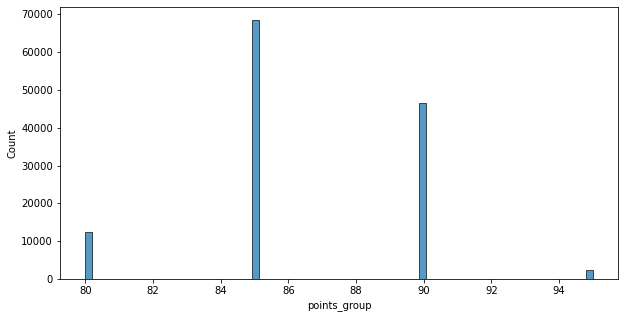

In [6]:
plt.figure(figsize=(10,5))
sns.histplot(data=df,
             x='points_group')

In [7]:
df['points_group'].value_counts()

85.0    68496
90.0    46629
80.0    12430
95.0     2416
Name: points_group, dtype: int64

### 3. Crie **df_price_per_group[['country', 'points_group', 'price']]** com as médias dos valores e faça merge left com **df**, substituia os valores nulos de **price** pelos de **price_per_group**. Informe a média de **price**

In [8]:
df_price_per_group = df[
                        ["country", 
                         "points_group",
                         "price"]
                         ].groupby(["country", "points_group"]).mean()

In [9]:
df_price = df.merge(df_price_per_group, 
                    on=['country', 'points_group'], 
                    how='left',
                    suffixes=('', '_per_group'))

In [10]:
df_price['price'].fillna(df_price['price_per_group'], inplace=True)

In [11]:
print(f'A nova média de price é US$ {df_price["price"].mean():.2f}')


A nova média de price é US$ 35.61


### 4. De acordo com o Z Score, informe os outliers de **price**

Recarregar o dataset

In [12]:
df = data.copy()

Retirar todos os valores nulos de **price**

In [13]:
df.dropna(subset=['price'],
          how='any', 
          axis='index', 
          inplace=True)

Calcular o Z Score

In [14]:
z = np.abs(stats.zscore(df['price'].values))

In [15]:
print(f'Existem {df[z>3].shape[0]} outliers na variável price')

Existem 1177 outliers na variável price


### 5. Filtre os 7 países mais representativos da variável **country** e informe o percentual de sua soma cumulativa

In [16]:
countries = list(df['country'].value_counts().head(7).index)

In [17]:
print(f"Os países {countries} representam "
      f"{(df['country'].value_counts().head(7).sum() / len(df['country'])) * 100:.0f} % "
      f"da variável country.")

Os países ['US', 'France', 'Italy', 'Spain', 'Portugal', 'Chile', 'Argentina'] representam 90 % da variável country.


### 6. One-Hot Encoding filtro **country** US, **province** com mais de 100 registros

In [18]:
df_us = df.loc[df['country'] == 'US']

In [19]:
def cat_filter(df, columns, entries):
  import pandas as pd
  filter = {}
  for col in columns:
    cat = df[col].value_counts()
    filter = {x: 'Other' for x in cat[cat < entries].index}
  df_new = df[columns].replace(filter).copy()
  df_new = pd.get_dummies(df, columns=columns, drop_first=True)
  return df_new

In [20]:
df_province = cat_filter(df_us, columns=['province'], entries= 100)

In [21]:

print(f'Serão necessárias mais {df_province.shape[1] - df_us.shape[1]} colunas')

Serão necessárias mais 25 colunas


### 7. Ao aplicar a transformação Box-Cox na variável **price**, encontre o valor de lambda

In [22]:
df = data.copy()

In [23]:
boxcox_transformer = PowerTransformer(method='box-cox', 
                                      standardize=False)
df['price_box-cox'] = boxcox_transformer.fit_transform(df[['price']])

[Text(0.5, 1.0, 'Imagem 2 - Distribuição da variável Price após transformação Box-Cox')]

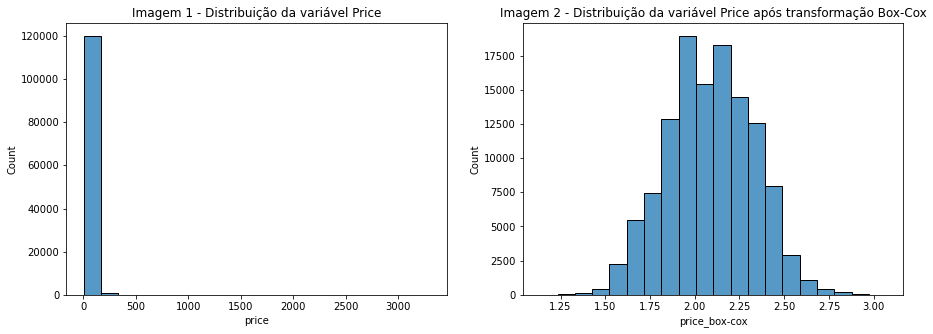

In [24]:
fig, axs = plt.subplots(nrows=1, 
                        ncols=2, 
                        figsize=(15, 5))

sns.histplot(data=df,
            x='price',
            bins=20,
            ax=axs[0]).set(title='Imagem 1 - Distribuição da variável Price')

sns.histplot(data=df,
            x='price_box-cox',
            bins=20,
            ax=axs[1]).set(title='Imagem 2 - Distribuição da variável Price após transformação Box-Cox')

In [25]:
print(f'O valor de lambda utilizado foi: {boxcox_transformer.lambdas_[0]:.3f}')

O valor de lambda utilizado foi: -0.296


### 8. Tratar **description** com NLP

In [26]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import string
import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bruna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bruna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
def clean_text(sentence):
    word_tokens = word_tokenize(sentence)
    new_words = [word for word in word_tokens
                if (word not in string.punctuation
                    and not re.match('[0-9]+', word))]
    clean_tokens = new_words[:]
    for token in clean_tokens:
        if token in stopwords.words('english'):
            clean_tokens.remove(token)
    return ' '.join(clean_tokens)


In [28]:
df['description_clean'] = df['description'].apply(clean_text)

In [29]:
pd.options.display.max_colwidth = 300
df[['description','description_clean']].head(10)

,description,description_clean
0,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Aromas include tropical fruit broom brimstone dried herb The palate n't overly expressive offering unripened apple citrus dried sage alongside brisk acidity
1,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",This ripe fruity wine is smooth still structured Firm tannins filled juicy red berry fruits freshened with acidity It 's already drinkable although will certainly better
2,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",Tart snappy flavors lime flesh rind dominate Some green pineapple pokes with crisp acidity underscoring flavors The wine all stainless-steel fermented
3,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Pineapple rind lemon pith orange blossom start the aromas The palate a bit opulent notes honey-drizzled guava mango giving way a slightly astringent semidry finish
4,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Much like regular bottling this comes across rather rough tannic rustic earthy herbal characteristics Nonetheless you think pleasantly unfussy country wine it 's a good companion a hearty winter stew
5,"Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and, in this case, horseradish. In the mouth, this is fairly full bodied, with tomatoey acidity. Spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby.",Blackberry raspberry aromas show typical Navarran whiff green herbs in case horseradish In mouth fairly full bodied tomatoey acidity Spicy herbal flavors complement dark plum fruit the finish is fresh grabby
6,"Here's a bright, informal red that opens with aromas of candied berry, white pepper and savory herb that carry over to the palate. It's balanced with fresh acidity and soft tannins.",Here 's bright informal red opens aromas candied berry white pepper savory herb carry to palate It 's balanced fresh acidity soft tannins
7,"This dry and restrained wine offers spice in profusion. Balanced with acidity and a firm texture, it's very much for food.",This dry restrained wine offers spice profusion Balanced acidity a firm texture 's much food
8,"Savory dried thyme notes accent sunnier flavors of preserved peach in this brisk, off-dry wine. It's fruity and fresh, with an elegant, sprightly footprint.",Savory dried thyme notes accent sunnier flavors preserved peach this brisk off-dry wine It 's fruity fresh an elegant sprightly footprint
9,This has great depth of flavor with its fresh apple and pear fruits and touch of spice. It's off dry while balanced with acidity and a crisp texture. Drink now.,This great depth flavor its fresh apple pear fruits touch spice It 's dry balanced acidity a crisp texture Drink


### 9. Encontre o preço médio por província e faça o cálculo de diferença com **price**

Importar novamente os dados e retirar os nulos de **price**

In [30]:
df = data.copy()
df.dropna(subset=['price'],
          how='any', 
          axis='index', 
          inplace=True)

Encontrar o preço médio por província e mesclar o resultado aos dados originais

In [31]:
province = df[['province', 'price']].groupby(['province']).mean()

In [32]:
df_pro = df.merge(province, 
                  on=['province'], 
                  how='left', 
                  suffixes=('', '_per_province'))

Calcular o delta entre **price** e **price_per_province**

In [33]:
def delta(df, col1, col2):
    df['diff'] = df[col1] - df[col2]
    df['delta'] = df['diff'].apply(lambda x: "Acima" if x > 0 else ("Abaixo" if x < 0 else "Null"))
    return df[[col1, col2, 'delta']]

In [34]:
delta(df_pro, 'price', 'price_per_province').head(3)

,price,price_per_province,delta
0,15.0,29.141975,Abaixo
1,14.0,36.545064,Abaixo
2,13.0,32.432432,Abaixo


In [35]:
df_pro[['province','price', 'price_per_province', 'delta']].head(5)

,province,price,price_per_province,delta
0,Douro,15.0,29.141975,Abaixo
1,Oregon,14.0,36.545064,Abaixo
2,Michigan,13.0,32.432432,Abaixo
3,Oregon,65.0,36.545064,Acima
4,Northern Spain,15.0,30.771925,Abaixo
